In [120]:
#%pip install scikeras
#%pip install spectral
#%pip install --upgrade matplotlib 
#%pip install scikit-optimize
#%pip install --upgrade tensorflow
#%pip install --upgrade keras
#%pip install tqdm
#%pip install -U tensorflow-addons
#%pip install lazypredict
%pip install seaborn


Note: you may need to restart the kernel to use updated packages.


In [121]:
#%pip install msvc-runtime

import os
from spectral import *
import numpy as np
import matplotlib.pyplot as plt
from lazypredict.Supervised import LazyClassifier
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, Input, Lambda
import scikeras
import scipy
import keras
from scikeras.wrappers import KerasClassifier, KerasRegressor
from scipy.stats import reciprocal
from sklearn.metrics import accuracy_score
# hyperparameter optimization methods
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective, plot_histogram, plot_evaluations
from skopt.callbacks import CheckpointSaver
#import optuna
#from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
#import hyperopt
import pickle
import pandas as pd
import skopt
from sklearn.model_selection import train_test_split, cross_val_score
import tqdm # nice progress bar
from scipy.signal import find_peaks

print(f'Numpy Version: {np. __version__}')
print(f'TensorFlow Version: {tf. __version__}')
print(f'Keras Version: {keras. __version__}')

# NOTE:  The 'from lazypredict.Supervised import LazyClassifier' gives this error:
# TypeError: OneHotEncoder.__init__() got an unexpected keyword argument 'sparse'
# to fix this, go into sklearn and switch
#    OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
#  to
#    OH_encoder = OneHotEncoder(handle_unknown='ignore')


Numpy Version: 2.0.2
TensorFlow Version: 2.18.0
Keras Version: 3.8.0


# Load the UPWINS spectral library and metadata csv

In [122]:
# Load the quality-checked spectra and metadata from numpy variables
spectra = np.load('data/spectra.npy')
wl = np.load('data/wl.npy')
genus = np.load('data/genus.npy')
species = np.load('data/species.npy')
principle_part = np.load('data/principle_part.npy')
health = np.load('data/health.npy')
growth_stage = np.load('data/growth_stage.npy')
DateTimeId = np.load('data/DateTimeId.npy')
month = np.load('data/month.npy')
name = np.load('data/name.npy')# the genus and species if known, otherwise the common name (or material name for soil, road, etc.)
name_genus_species = np.load('data/name_genus_species.npy')# the genus and species if known - otherwise NA
name_full_category = np.load('data/name_full_category.npy')# all the metadata available in one string
plant_type = np.load('data/plant_type.npy')# the type of plant (tree, shrub, grass, etc.) - otherwise NA

nSpec = spectra.shape[0]
nBands = spectra.shape[1]
print(f'Min wavelength: {np.min(wl)}')
print(f'Max wavelength: {np.max(wl)}')
print(f'Number of Spectra: {nSpec}')
print(f'Number of Bands: {nBands}')

Min wavelength: 350.0
Max wavelength: 2500.0
Number of Spectra: 902
Number of Bands: 2151


# Prepare the data for training and testing

In [123]:
# Assemble X and Y for training
X_o = spectra
Yn_o = name
Yg_o = genus
Ys_o = species
Ypp_o = principle_part
Yh_o = health
Ygs_o = growth_stage
Yd_o = DateTimeId
Ym_o = month
Yngs_o = name_genus_species
Ynfc_o = name_full_category
Ypt_o = plant_type
print(X_o.shape,Yn_o.shape)
print(f'Number of genus: {len(np.unique(Yg_o))}: {np.unique(Yg_o)}\n')
print(f'Number of species: {len(np.unique(Ys_o))}: {np.unique(Ys_o)}\n')
print(f'Number of principle_parts: {len(np.unique(Ypp_o))}: {np.unique(Ypp_o)}\n')
print(f'Number of health categories: {len(np.unique(Yh_o))}: {np.unique(Yh_o)}\n')
print(f'Number of growth stage categories: {len(np.unique(Ygs_o))}: {np.unique(Ygs_o)}\n')
print(f'Number of Date-Time_Id values: {len(np.unique(Yd_o))}\n')
print(f'Number of months: {len(np.unique(Ym_o))}: {np.unique(Ym_o)}\n')
print(f'Number of names: {len(np.unique(Yn_o))}: {np.unique(Yn_o)}\n')
print(f'Number of name_genus_species categories: {len(np.unique(Yngs_o))}: {np.unique(Yngs_o)}\n')
print(f'Number of name_full_categories: {len(np.unique(Ynfc_o))}\n')
print(f'Number of plant types: {len(np.unique(Ypt_o))}: {np.unique(Ypt_o)}\n')

(902, 2151) (902,)
Number of genus: 10: ['Ammophila' 'Baccharis' 'Chamaecrista' 'Chasmanthium' 'Ilex' 'Iva' 'NA'
 'Panicum' 'Rosa' 'Solidago']

Number of species: 11: ['NA' 'amarum' 'breviligulata' 'fasciculata' 'frutescens' 'halimifolia'
 'latifolium' 'rugosa' 'sempervirens' 'virgatum' 'vomitoria']

Number of principle_parts: 10: ['B' 'CS' 'FL' 'L' 'MX' 'NA' 'RS' 'S' 'SA' 'St']

Number of health categories: 7: ['D' 'H' 'LLRZ' 'MX' 'NA' 'R' 'S']

Number of growth stage categories: 8: [' M' '1G' 'D' 'E' 'FL' 'M' 'NA' 'RE']

Number of Date-Time_Id values: 902

Number of months: 8: ['01' '02' '03' '04' '07' '10' '11' '12']

Number of names: 18: ['Ammophila_breviligulata' 'Baccharis_halimifolia'
 'Chamaecrista_fasciculata' 'Chasmanthium_latifolium' 'Ilex_vomitoria'
 'Iva_frutescens' 'Panicum_amarum' 'Panicum_virgatum' 'Rosa_rugosa'
 'Solidago_sempervirens' 'clay' 'golf-course-sand' 'grass' 'iris'
 'milkweed' 'pasturegrass' 'soybean' 'timothy']

Number of name_genus_species categories: 11: 

# Analysis of Baccharis_halimifolia vs Ilex_vomitoria

In [124]:
species_1 = 'Baccharis_halimifolia'
species_2 = 'Ilex_vomitoria'

# compute the indices for these species
idx_1 = np.where(Yn_o==species_1)[0]
idx_2 = np.where(Yn_o==species_2)[0]
idx = np.concatenate((idx_1, idx_2))

nSpec = len(idx)

In [125]:
# Assemble X and Y for training
X = spectra[idx,:]
Yn = name[idx]
Yg = genus[idx]
Ys = species[idx]
Ypp = principle_part[idx]
Yh = health[idx]
Ygs = growth_stage[idx]
Yd = DateTimeId[idx]
Ym = month[idx]
Yngs = name_genus_species[idx]
Ynfc = name_full_category[idx]
Ypt = plant_type[idx]
print(X.shape,Yn.shape)

(180, 2151) (180,)


In [126]:
Y_type = Yn
Y_labels = np.unique(Y_type)
nClasses = len(Y_labels)
Y = np.zeros(nSpec, dtype=int)
for i in range(nSpec):
    Y[i] = np.where(Y_labels == Y_type[i])[0]
print(f'Categories for classificaiton: {Y}')
nClasses =len(Y_labels)
print(f'Number of classes: {nClasses}')

Categories for classificaiton: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Number of classes: 2


In [127]:
# Create a test-train split
X_train80, X_test, Y_train80, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42) # 20% of the data in the test set
X_train, X_val, Y_train, Y_val = train_test_split(X_train80, Y_train80, test_size=0.25, random_state=42) # 20% of the data in the validation set, 60% in the training set
print(X_train.shape,Y_train.shape[0] / Y.shape[0])
print(X_test.shape,Y_test.shape[0] / Y.shape[0])
print(X_val.shape,Y_val.shape[0] / Y.shape[0])

(108, 2151) 0.6
(36, 2151) 0.2
(36, 2151) 0.2


In [128]:
# Classification results using lazy classifier
rerun_LazyClassifier = True
if rerun_LazyClassifier:
    clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
    models,predictions = clf.fit(X_train80, X_test, Y_train80, Y_test)
    models.to_csv(f'output/LazyClassifier_results_2_categories.csv')
else:
    models = pd.read_csv('output/LazyClassifier_results_2_categories.csv')
models

 97%|█████████▋| 31/32 [00:12<00:00,  2.81it/s]

[LightGBM] [Info] Number of positive: 53, number of negative: 91
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106708
[LightGBM] [Info] Number of data points in the train set: 144, number of used features: 2151
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.368056 -> initscore=-0.540568
[LightGBM] [Info] Start training from score -0.540568
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

100%|██████████| 32/32 [00:12<00:00,  2.49it/s]


Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LinearDiscriminantAnalysis         1.00               1.00     1.00      1.00   
LinearSVC                          1.00               1.00     1.00      1.00   
RidgeClassifier                    1.00               1.00     1.00      1.00   
LogisticRegression                 1.00               1.00     1.00      1.00   
RidgeClassifierCV                  1.00               1.00     1.00      1.00   
SGDClassifier                      0.97               0.98     0.98      0.97   
PassiveAggressiveClassifier        0.97               0.98     0.98      0.97   
LGBMClassifier                     0.97               0.96     0.96      0.97   
ExtraTreesClassifier               0.97               0.96     0.96      0.97   
ExtraTreeClassifier                0.94               0.96     0.96      0.95   
RandomForestClassifier             0.94               0.94     0.94      0.94   
DecisionTreeClassifier             0.94               0.94     0.94      0.94   
AdaBoostClassifier                 0.94               0.94     0.94      0.94   
BaggingClassifier                  0.94               0.94     0.94      0.94   
CalibratedClassifierCV             0.94               0.92     0.92      0.94   
NuSVC                              0.94               0.92     0.92      0.94   
LabelSpreading                     0.94               0.92     0.92      0.94   
LabelPropagation                   0.94               0.92     0.92      0.94   
SVC                                0.94               0.92     0.92      0.94   
KNeighborsClassifier               0.92               0.88     0.88      0.91   
Perceptron                         0.89               0.88     0.88      0.89   
QuadraticDiscriminantAnalysis      0.89               0.85     0.85      0.88   
BernoulliNB                        0.81               0.81     0.81      0.81   
NearestCentroid                    0.69               0.71     0.71      0.70   
GaussianNB                         0.78               0.71     0.71      0.76   
DummyClassifier                    0.64               0.50     0.50      0.50   

                               Time Taken  
Model                                      
LinearDiscriminantAnalysis           0.19  
LinearSVC                            0.39  
RidgeClassifier                      0.14  
LogisticRegression                   0.20  
RidgeClassifierCV                    0.21  
SGDClassifier                        0.12  
PassiveAggressiveClassifier          0.17  
LGBMClassifier                       0.81  
ExtraTreesClassifier                 0.35  
ExtraTreeClassifier                  0.09  
RandomForestClassifier               0.75  
DecisionTreeClassifier               0.18  
AdaBoostClassifier                   3.16  
BaggingClassifier                    1.16  
CalibratedClassifierCV               1.46  
NuSVC                                0.12  
LabelSpreading                       0.17  
LabelPropagation                     0.11  
SVC                                  0.16  
KNeighborsClassifier                 0.12  
Perceptron                           0.11  
QuadraticDiscriminantAnalysis        0.20  
BernoulliNB                          0.28  
NearestCentroid                      0.12  
GaussianNB                           0.10  
DummyClassifier                      0.11

# Build an initial NN model

In [129]:
# Model with one hidden layer (128 neurons) with dropout (probability = 0.2), with one final layer.
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.01) #<- if we want to control initial weights

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(nClasses, activation='softmax')
])

# Comile the layer -> set the optimizer, loss function, and metrics to track.
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fit (train) the model
history = model.fit(X_train80, Y_train80, epochs=500, batch_size=32);

Epoch 1/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4994 - loss: 1.1687
Epoch 2/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4570 - loss: 0.8267
Epoch 3/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6713 - loss: 0.6020
Epoch 4/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6651 - loss: 0.6361
Epoch 5/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5910 - loss: 0.6702
Epoch 6/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7448 - loss: 0.5824
Epoch 7/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6168 - loss: 0.6342
Epoch 8/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7454 - loss: 0.5629
Epoch 9/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7656 - loss: 0.5930
Epoch 10/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7620 - loss: 0.5343
Epoch 11/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8022 - loss: 0.5274
Epoch 12/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8079 - lo

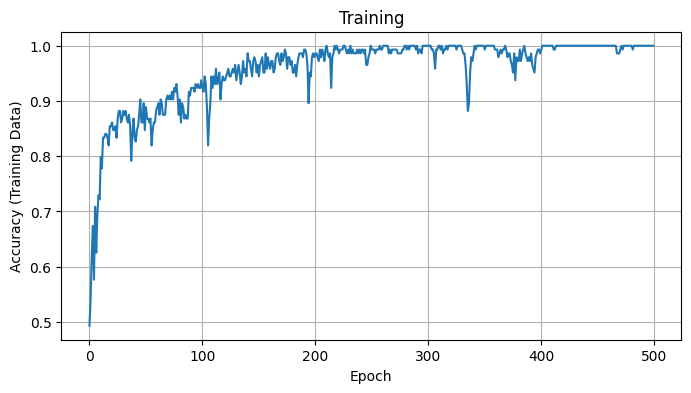

In [130]:
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'])
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (Training Data)')
plt.title('Training');
plt.savefig('trainingHistoryAccuracy.png')

In [131]:
test_loss, test_acc = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest accuracy:', test_acc)

2/2 - 0s - 133ms/step - accuracy: 0.9722 - loss: 0.0510

Test accuracy: 0.9722222089767456


In [132]:
predicted = model.predict(X_test)
actual = tf.stack(Y_test, axis=0)
predicted = tf.concat(predicted, axis=0)
predicted = tf.argmax(predicted, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


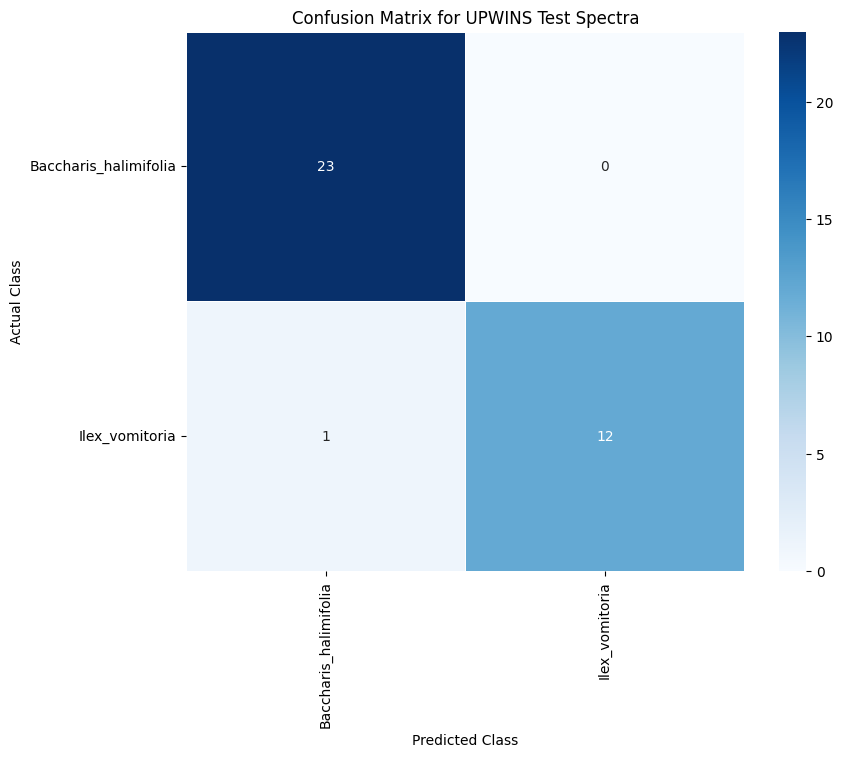

In [133]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
    fig, ax = plt.subplots(figsize=(9,7)) 
    cm = tf.math.confusion_matrix(actual, predicted)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', linewidth=.5, ax=ax)
    ax.set_title('Confusion Matrix for UPWINS Test Spectra')
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('Actual Class')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

plot_confusion_matrix(actual, predicted, Y_labels, 'test')
plt.savefig('confusionMatrix.png')

In [134]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 128)            │       275,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 827,144 (3.16 MB)

 Trainable params: 275,714 (1.05 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 551,430 (2.10 MB)

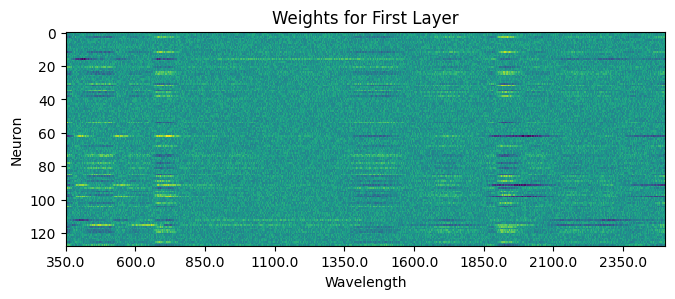

In [135]:
# Visualize the first layer as an image
hidden = model.layers[0]
hidden.name
weights_1, biases_1 = hidden.get_weights()

plt.figure(figsize=(8,3))
plt.imshow(weights_1.T, aspect='6', interpolation='none');
plt.xlabel('Wavelength');
plt.ylabel('Neuron');
ax = plt.gca();
x_wl_labels = np.insert(wl[np.linspace(0,2000,9, dtype=int)], 0, 0);
ax.set_xticklabels(x_wl_labels);
plt.title('Weights for First Layer');
plt.tight_layout()
plt.savefig('output/Layer1WeightsImAll.png')

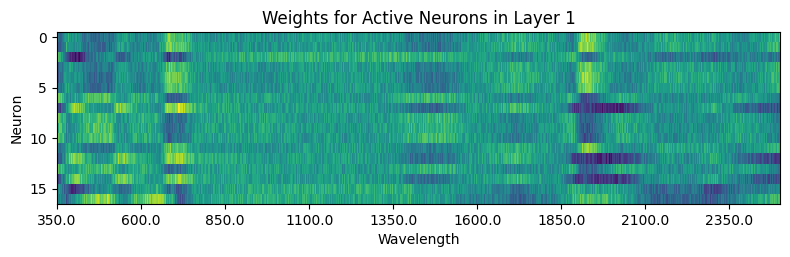

In [136]:
# determine the indices for neurons with structure
indices = np.where(np.std(weights_1, axis=0) > 0.05)[0]
active_weights_1 = weights_1[:,indices].T
active_biases_1 = biases_1[indices]

plt.figure(figsize=(8,3))
plt.imshow(active_weights_1, aspect='30', interpolation='none');
plt.xlabel('Wavelength');
plt.ylabel('Neuron');
ax = plt.gca();
x_wl_labels = np.insert(wl[np.linspace(0,2000,9, dtype=int)], 0, 0);
ax.set_xticklabels(x_wl_labels);
plt.title('Weights for Active Neurons in Layer 1');
plt.tight_layout()
plt.savefig('output/Layer1WeightsIm.png')

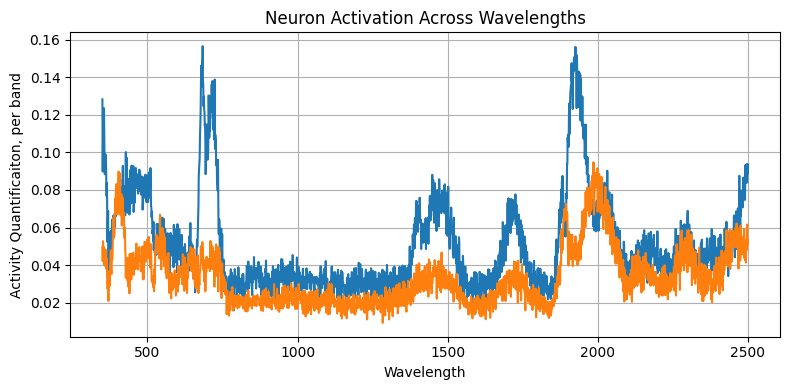

In [137]:
activity = np.mean(np.abs(active_weights_1),axis=0)
activity_var = np.std(np.abs(active_weights_1),axis=0)

plt.figure(figsize=(8,4))
plt.plot(wl,activity, label='Mean Absulte Value of Weight')
plt.plot(wl,activity_var, label='Standard deviation in Weight')
plt.xlabel('Wavelength')
plt.ylabel('Activity Quantificaiton, per band')
plt.title('Neuron Activation Across Wavelengths')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/NeuronActivityPerWL.png')

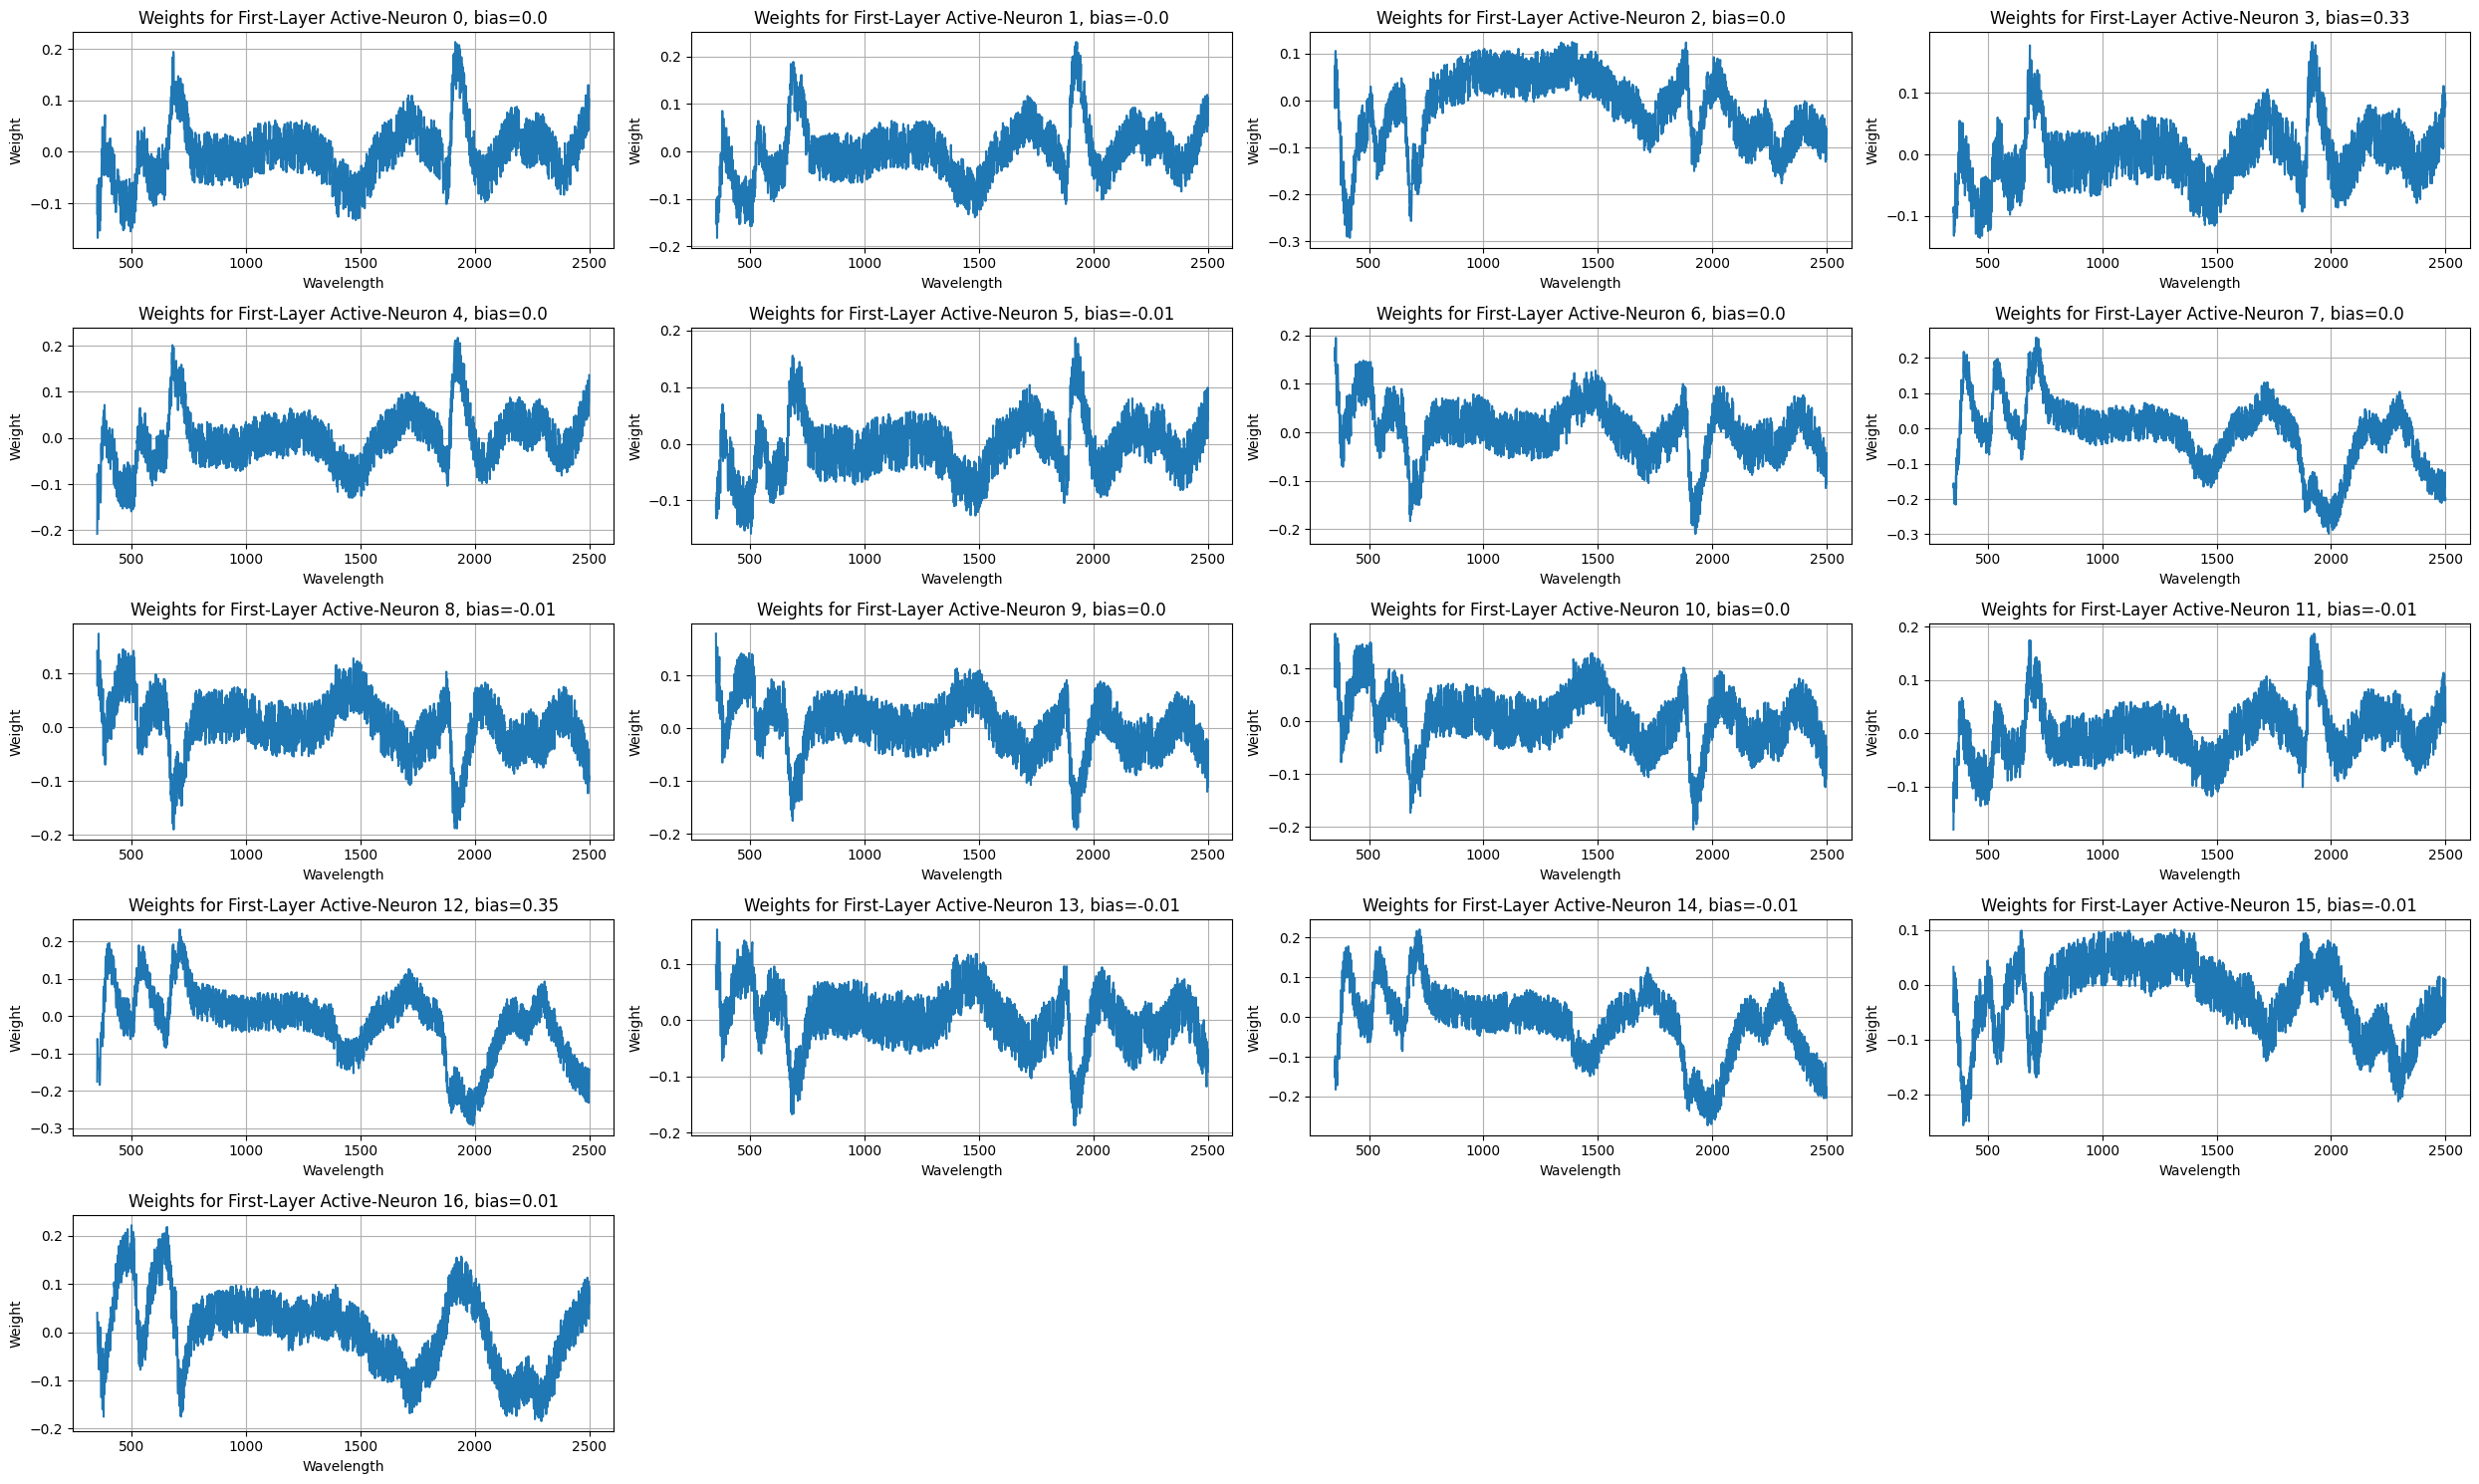

In [138]:
# plot the weights for each active weight in the first layer
rows = int(np.ceil(len(indices)/4))

fig = plt.figure(figsize=(25,15))
for i in range(len(indices)):
    fig.add_subplot(rows,4,i+1)
    plt.plot(wl,active_weights_1[i,:])
    plt.xlabel('Wavelength')
    plt.ylabel('Weight')
    plt.grid(True)
    plt.title(f'Weights for First-Layer Active-Neuron {i}, bias={str(round(biases_1[i], 2))}')
plt.tight_layout()
plt.savefig('output/Layer1NeuronWeights.png')

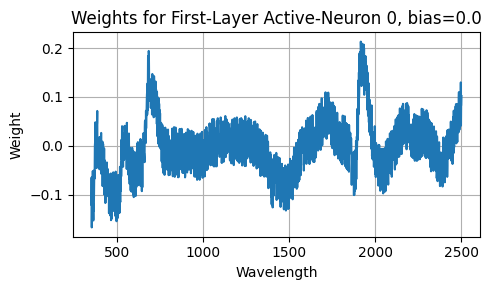

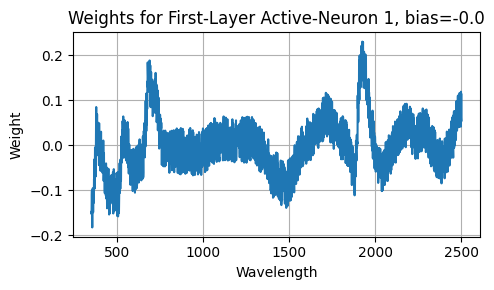

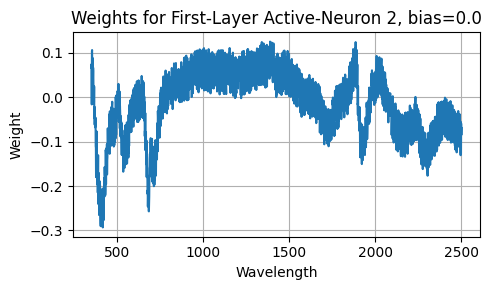

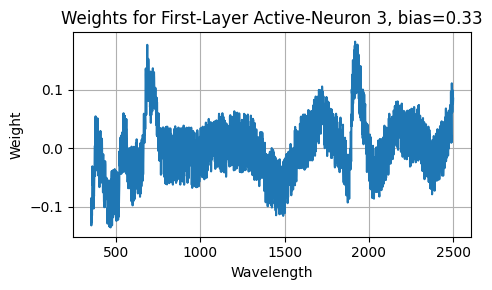

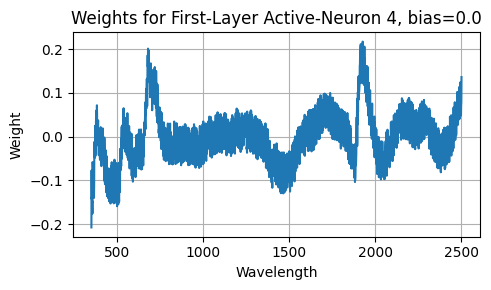

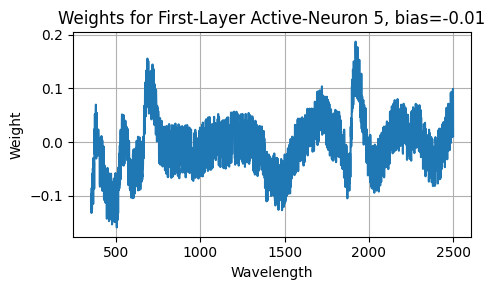

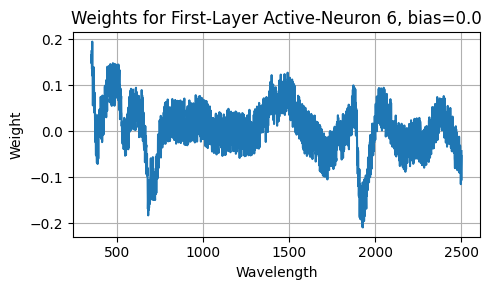

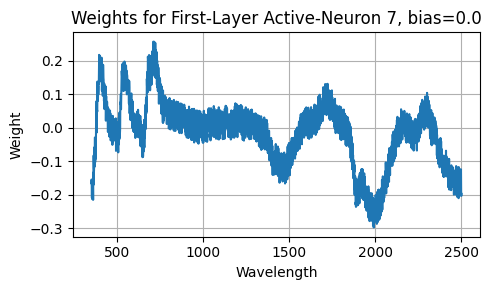

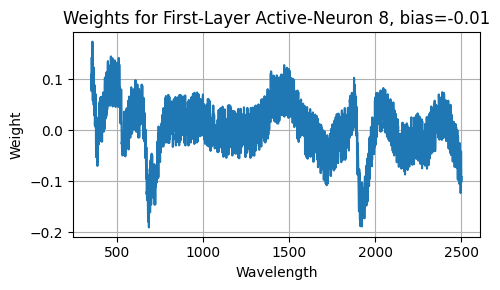

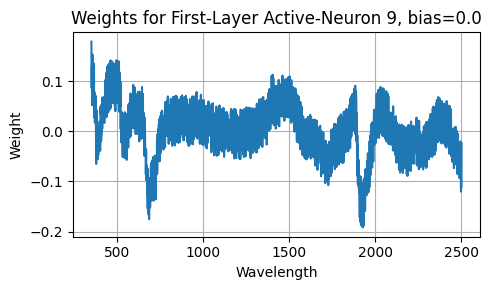

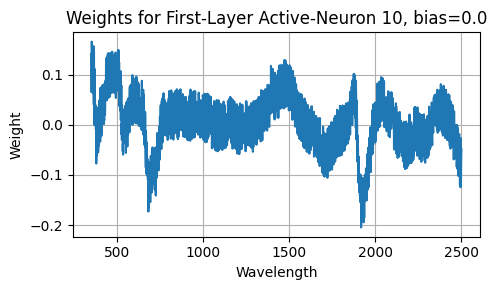

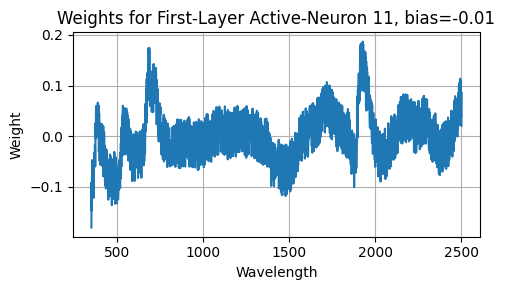

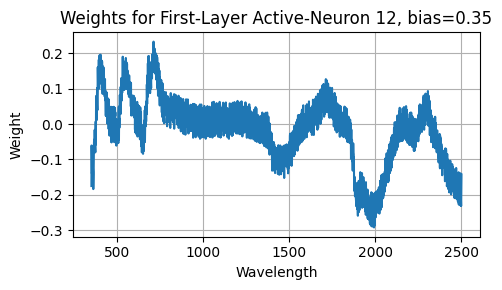

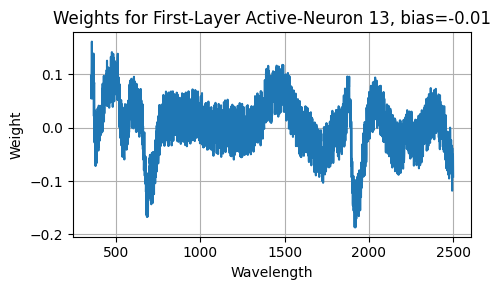

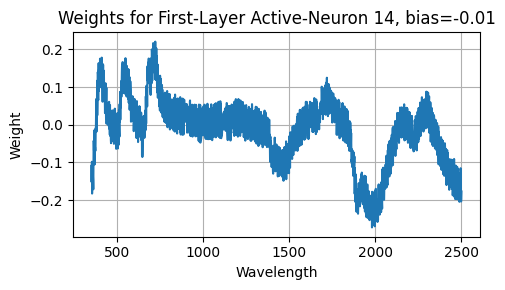

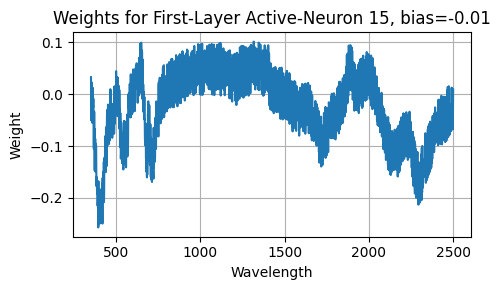

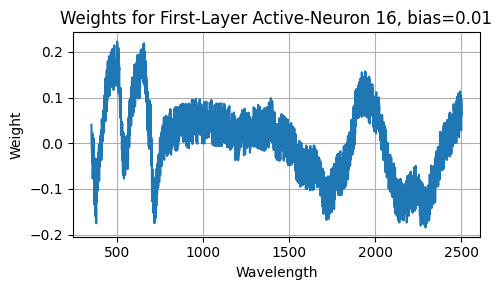

In [139]:
# plot the weights for each active weight in the first layer
for i in range(len(indices)):
    plt.figure(figsize=(5,3))
    plt.plot(wl,active_weights_1[i,:])
    plt.xlabel('Wavelength')
    plt.ylabel('Weight')
    plt.grid(True)
    plt.title(f'Weights for First-Layer Active-Neuron {i}, bias={str(round(biases_1[i], 2))}')
    plt.tight_layout()
    plt.savefig('output/Layer1NeuronWeights_'+str(i)+'.png')

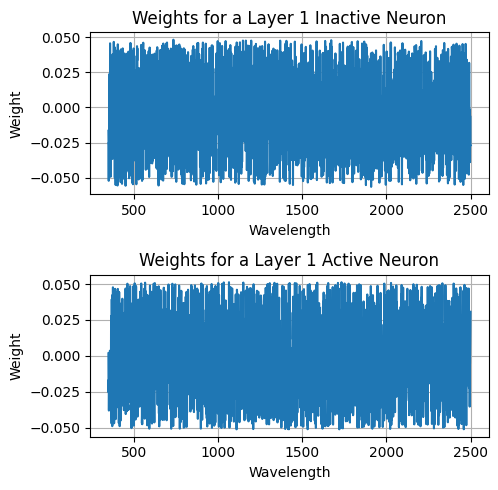

In [140]:
# plot activations for one active neruon and one inactive neuron
i_inact = 1
i_act = 4
fig = plt.figure(figsize=(5,5))

fig.add_subplot(2,1,1)
plt.plot(wl,weights_1[:,i_inact])
plt.xlabel('Wavelength')
plt.ylabel('Weight')
plt.grid(True)
plt.title(f'Weights for a Layer 1 Inactive Neuron');

fig.add_subplot(2,1,2)
plt.plot(wl,weights_1[:,i_act])
plt.xlabel('Wavelength')
plt.ylabel('Weight')
plt.grid(True)
plt.title(f'Weights for a Layer 1 Active Neuron');

plt.tight_layout()
plt.savefig('output/activeAndInactiveNeurons.png')

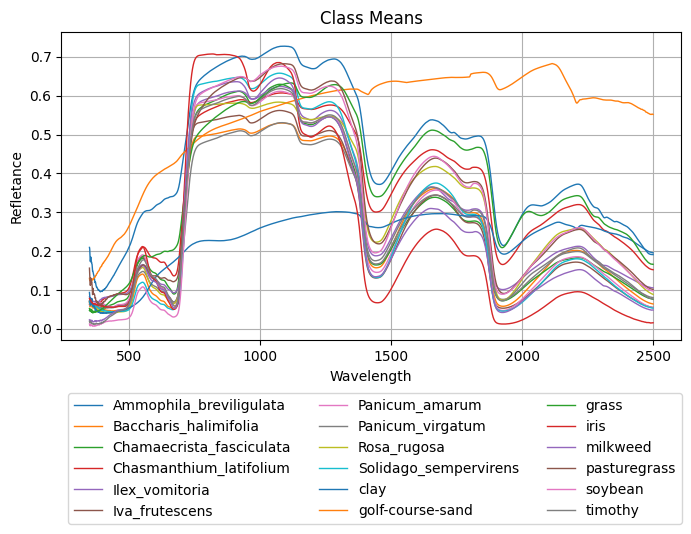

In [141]:
# plot the mean of each class
plt.figure(figsize=(8,4))
plt.grid(True)
for n in np.unique(name):
    idx = np.where(name==n)[0]
    mean_spectrum = np.mean(spectra[idx,:], axis=0)
    plt.plot(wl, mean_spectrum, label=n, lw=1)
plt.xlabel('Wavelength')
plt.ylabel('Refletance')
plt.title('Class Means')
plt.legend(bbox_to_anchor=(0.0, -0.15), ncols=3, loc='upper left');
plt.savefig('output/meanSpectra.png')

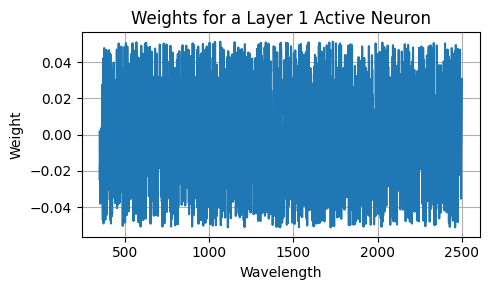

In [142]:
i=4
plt.figure(figsize=(5,3))
plt.plot(wl,weights_1[:,i])
plt.xlabel('Wavelength')
plt.ylabel('Weight')
plt.grid(True)
plt.title(f'Weights for a Layer 1 Active Neuron');
plt.tight_layout()
plt.savefig('output/activeNeuron.png')

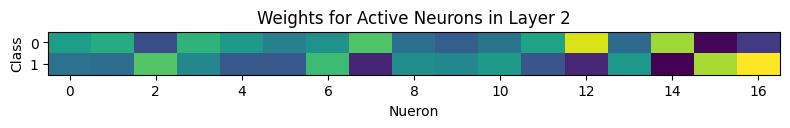

In [143]:
# Visualize the second layer as an image
hidden = model.layers[1]
hidden.name
weights_2, biases_2 = hidden.get_weights()
active_weights_2 = weights_2[indices,:].T

plt.figure(figsize=(8,4))
plt.imshow(active_weights_2, aspect='0.5', interpolation='none');
plt.xlabel('Nueron');
plt.ylabel('Class');
plt.title('Weights for Active Neurons in Layer 2');
plt.tight_layout()
plt.savefig('output/Layer2WeightsIm.png')

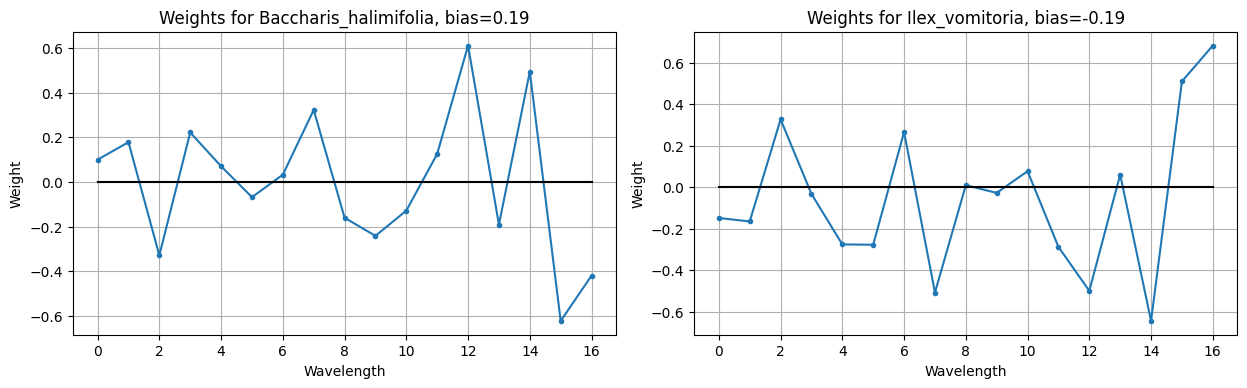

In [144]:
fig = plt.figure(figsize=(25,18))
for i in range(nClasses):
    fig.add_subplot(5,4,i+1)
    plt.plot(active_weights_2[i,:], '.-')
    plt.plot(np.zeros(len(active_weights_2[i,:])), c='k')
    plt.xlabel('Wavelength')
    plt.ylabel('Weight')
    plt.grid(True)
    plt.title(f'Weights for {Y_labels[i]}, bias={str(round(biases_2[i], 2))}')
plt.tight_layout()
plt.savefig('output/Layer2ClassWeights.png')

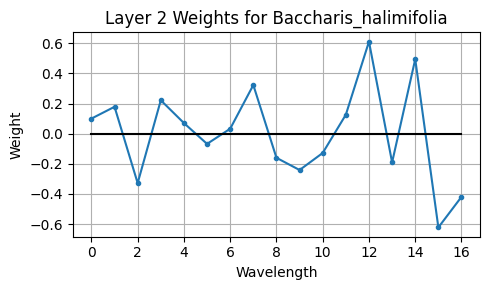

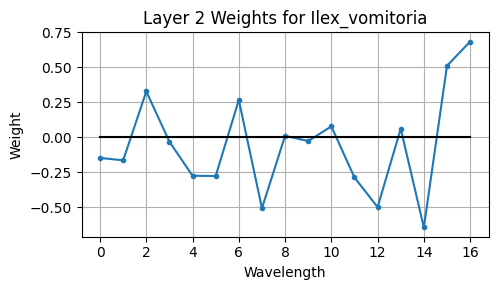

In [145]:
# plot the weights for each active weight in the first layer
for i in range(nClasses):
    plt.figure(figsize=(5,3))
    plt.plot(active_weights_2[i,:], '.-')
    plt.plot(np.zeros(len(active_weights_2[i,:])), c='k')
    plt.xlabel('Wavelength')
    plt.ylabel('Weight')
    plt.grid(True)
    plt.title(f'Layer 2 Weights for {Y_labels[i]}')
    plt.tight_layout()
    plt.savefig('output/Layer2ClassWeights_'+Y_labels[i]+'.png')

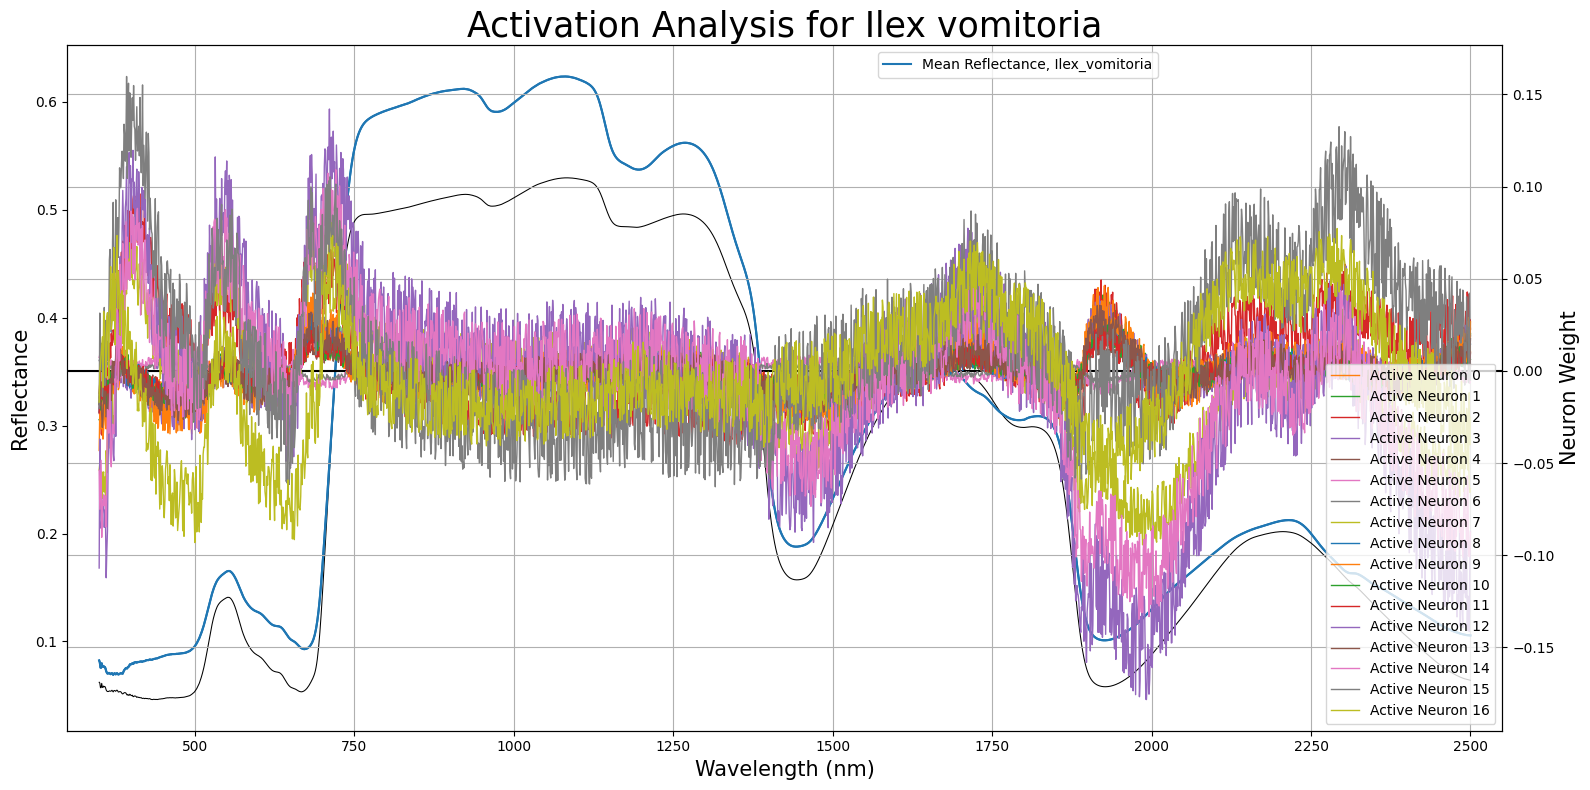

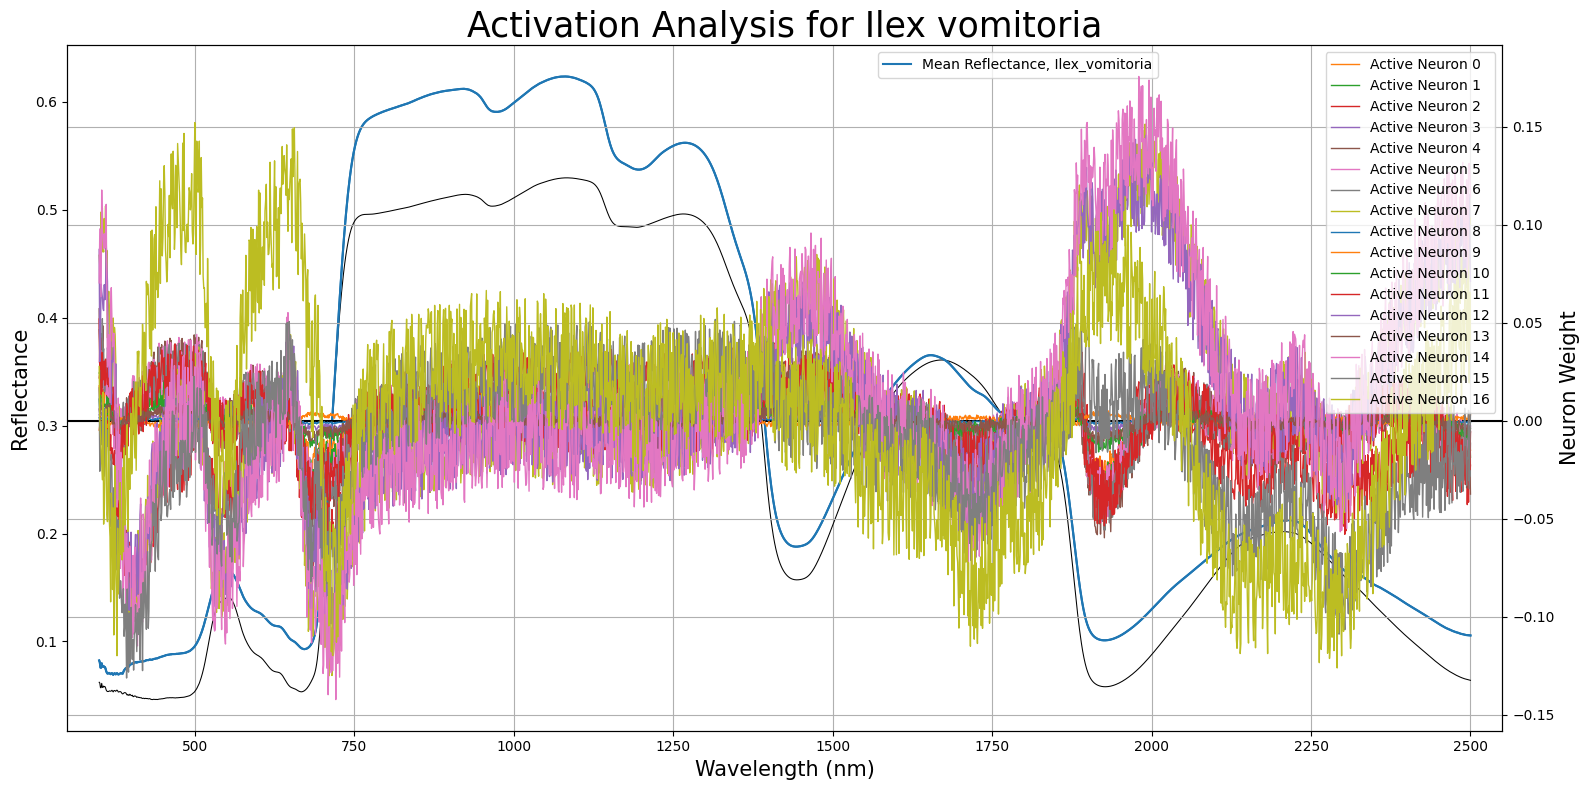

In [146]:
def plot_class_with_activation(class_name):
    
    # Compute the mean spectrum for this class
    class_mean = np.mean(spectra[np.where(name==class_name)[0],:], axis=0)
    # Compute the index in Y_labels for the name of this class
    name_index = np.where(Y_labels==class_name)[0] 
    # Determine the indices for the neurons in the first layer that are active for this class
    neuron_indices = np.where(np.abs(active_weights_2[name_index,:].flatten())>0)[0] 
    # Determine the amount of activation (weights in second layer) for this class
    neuron_activation = active_weights_2[name_index,neuron_indices]

    c = plt.rcParams['axes.prop_cycle'].by_key()['color'] # list of the default matplotlib colors
    
    fig, ax1 = plt.subplots(figsize=(16,8))
    for class_name in Y_labels:
        class_mean = np.mean(spectra[np.where(name==class_name)[0],:], axis=0)
        ax1.plot(wl,class_mean, color='k', lw=0.75)
    ax1.set_xlabel('Wavelength (nm)', fontsize=15) # first axis, for the spectrum
    ax1.set_ylabel('Reflectance', color='k', fontsize=15)
    ax1.plot(wl,class_mean, color=c[0], label=f'Mean Reflectance, {class_name}')
    ax1.tick_params(axis='y', labelcolor='k')
    plt.grid(True, axis='x')
    plt.legend(loc='upper left', bbox_to_anchor=(0.56,1))

    ax2 = ax1.twinx()  # second axes, for neruon weights
    ax2.set_ylabel('Neuron Weight', color='k', fontsize=15) 
    ax2.plot([np.min(wl)-50,np.max(wl)+50], [0,0], color='k', alpha=1)
    for i,n_i in enumerate(neuron_indices):
        color_index = (i+1) % (len(c)-1) # pick the next color looping through the list
        ax2.plot(wl, neuron_activation[i]*active_weights_1[n_i,:].flatten(), 
                 color=c[color_index], lw=1, label='Active Neuron '+str(n_i))
    ax2.tick_params(axis='y', labelcolor='k')
    ax2.grid(True)

    ax1.plot(wl,class_mean, color=c[0])
    plt.title(f'Activation Analysis for '+class_name.replace('_', ' '), fontsize=25)
    plt.xlim(np.min(wl)-50,np.max(wl)+50)
    plt.legend()
    fig.tight_layout()  
    plt.savefig('output/activation_'+class_name+'.png');
    plt.show()

for class_name in Y_labels:
    plot_class_with_activation(class_name)
    

In [155]:
def normalize_spec(spec, normalize_spectra):
    if normalize_spectra:
        spec = spec/np.max(spec)
    return spec

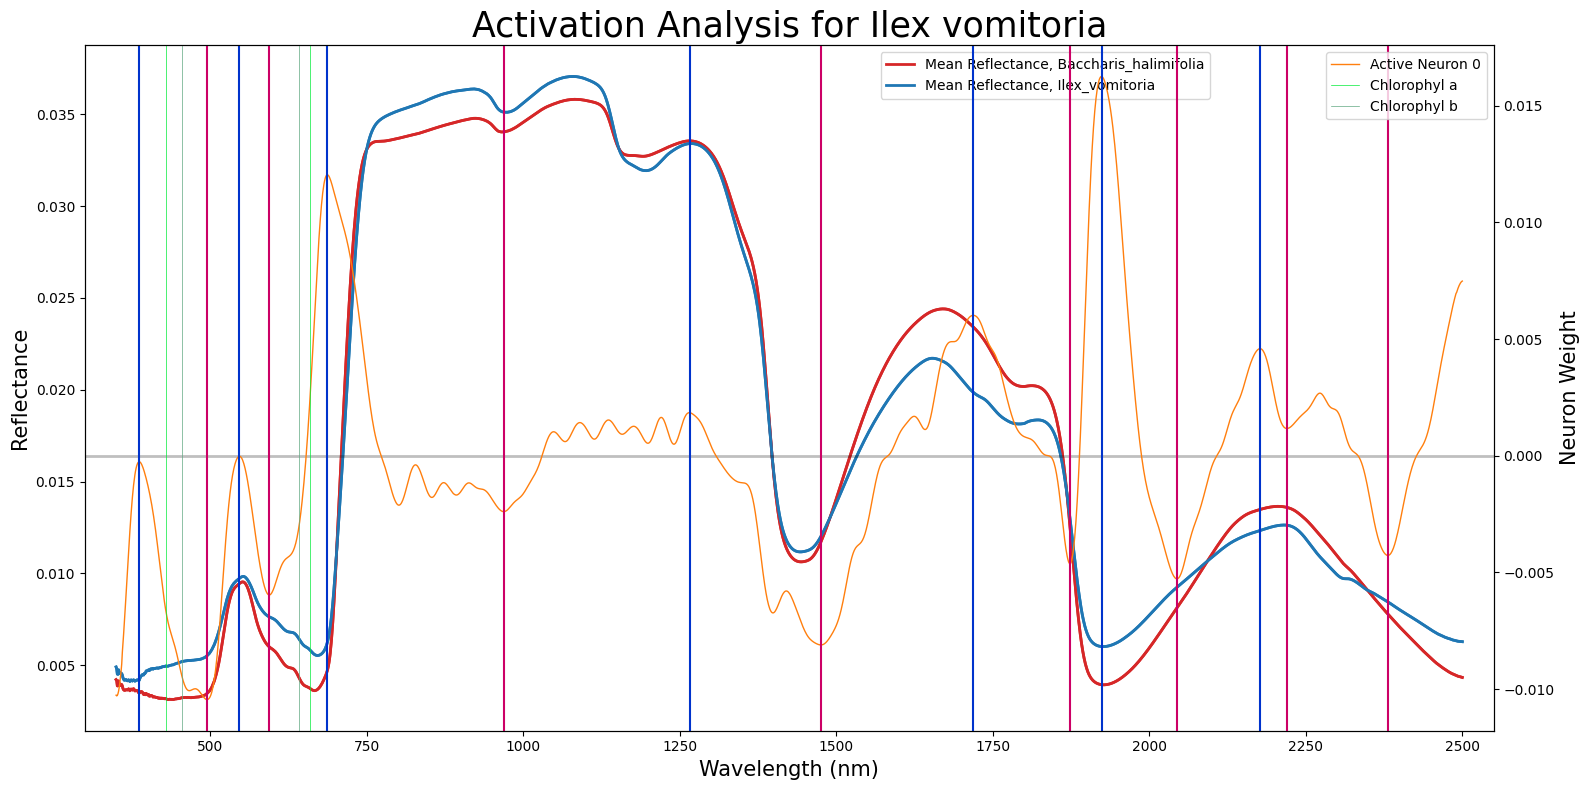

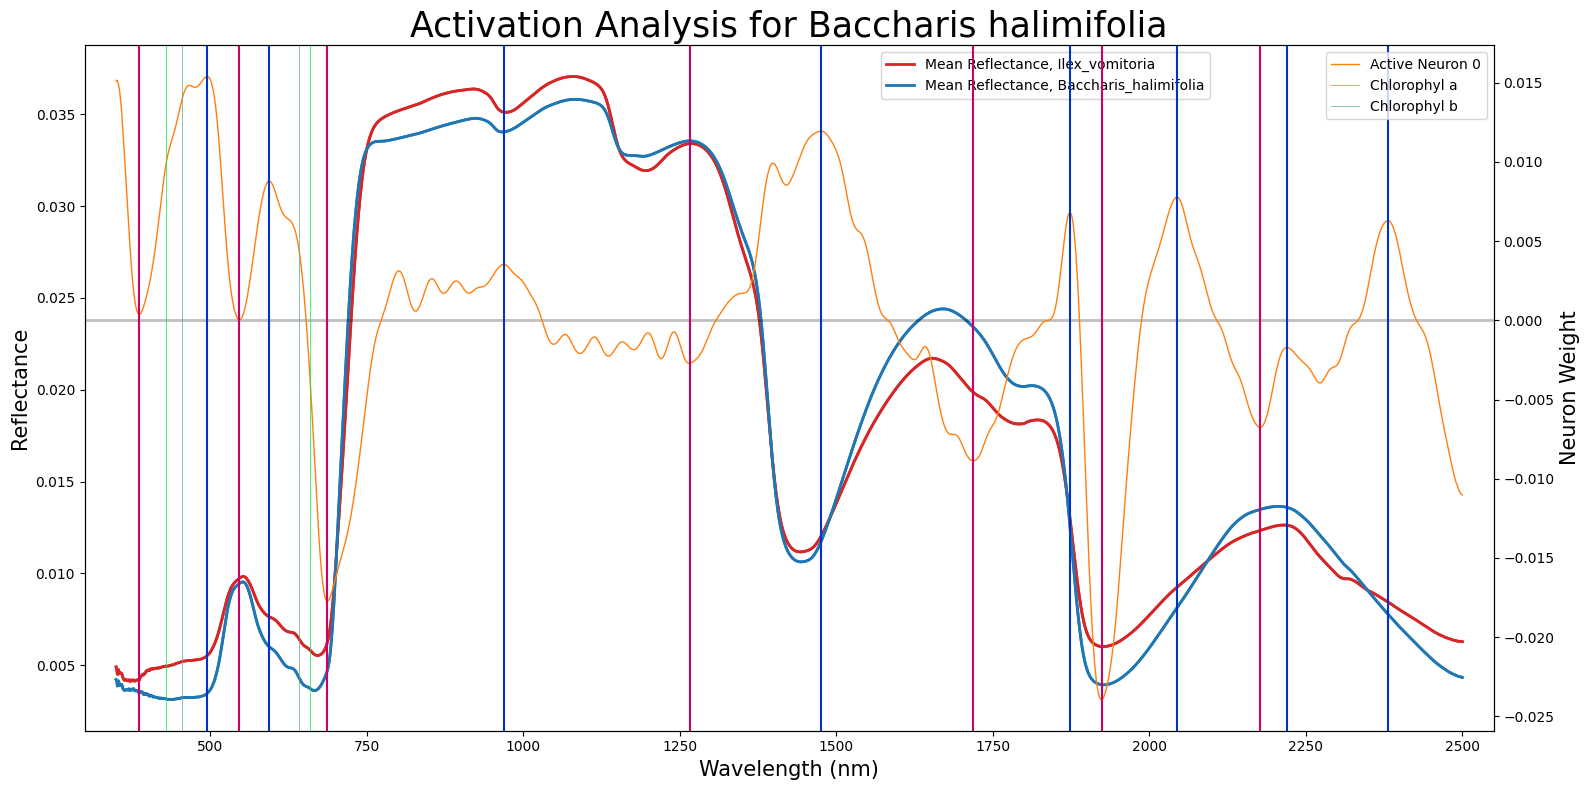

In [148]:
def plot_class_with_activation(max_neurons=4, smooth=True, plot_all_spectra = True, normalize_spectra=True, show_chlorophyl=True, lines_on_peaks=True):
    
    for idx in [[0,1],[1,0]]:
    
        # parameters for smoothing the neurons
        sigma = 10
        window = 20
        
        # Compute the mean spectrum for this class
        #class_mean = np.mean(spectra[np.where(name==class_name)[0],:], axis=0)
        # Compute the index in Y_labels for the name of this class
        #name_index = np.where(Y_labels==class_name)[0] 
        name_index = idx[0]
        # Determine the indices for the neurons in the first layer that are active for this class
        neuron_indices = np.where(np.abs(active_weights_2[name_index,:].flatten())>0)[0] 
        # Determine the amount of activation (weights in second layer) for this class
        neuron_activation = active_weights_2[name_index,neuron_indices]

        c = plt.rcParams['axes.prop_cycle'].by_key()['color'] # list of the default matplotlib colors
        
        fig, ax1 = plt.subplots(figsize=(16,8))
        # plot spectra from both classes
        for class_name, color in zip([Y_labels[idx[0]], Y_labels[idx[1]]], ['tab:red','tab:blue']):
            # plot class mean for alternative class
            class_mean = np.mean(spectra[np.where(name==class_name)[0],:], axis=0)
            ax1.plot(wl, normalize_spec(class_mean, normalize_spectra), color=color, lw=2, label=f'Mean Reflectance, {class_name}')
            # plot each spectra in the alternative class
            if plot_all_spectra:
                for i in np.where(name==class_name)[0]:
                    ax1.plot(wl, normalize_spec(spectra[i,:], normalize_spectra), color=color, lw=0.25, alpha=0.5)
                
        ax1.set_xlabel('Wavelength (nm)', fontsize=15) # first axis, for the spectrum
        ax1.set_ylabel('Reflectance', color='k', fontsize=15)
        ax1.tick_params(axis='y', labelcolor='k')
        plt.grid(False)
        plt.legend(loc='upper left', bbox_to_anchor=(0.56,1))

        ax2 = ax1.twinx()  # second axes, for neruon weights
        ax2.set_ylabel('Neuron Weight', color='k', fontsize=15) 
        ax2.plot([np.min(wl)-50,np.max(wl)+50], [0,0], color='k', alpha=0.25, lw=2)
        for i,n_i in enumerate(neuron_indices):
            color_index = (i+1) % (len(c)-1) # pick the next color looping through the list
            neuronACt = neuron_activation[i]*active_weights_1[n_i,:].flatten()
            if smooth:
                neuronACt = scipy.ndimage.gaussian_filter1d(neuronACt, sigma)
                neuronACt = scipy.signal.savgol_filter(neuronACt, window, 3)
                neuronACt = scipy.signal.savgol_filter(neuronACt, window, 3)
            ax2.plot(wl, neuronACt, color=c[color_index], lw=1, label='Active Neuron '+str(n_i))
            if lines_on_peaks:
                peaks, _ = find_peaks(neuronACt, rel_height=0.05, width=10)
                for peak_index in peaks:
                    plt.axvline(x=wl[peak_index], color='#0033cc')
                peaks, _ = find_peaks(-neuronACt, rel_height=0.05, width=10)
                for peak_index in peaks:
                    plt.axvline(x=wl[peak_index], color='#cc0066')
            if i == max_neurons-1:
                break
        ax2.tick_params(axis='y', labelcolor='k')
        ax2.grid(False)

        for class_name, color in zip([Y_labels[idx[0]], Y_labels[idx[1]]], ['tab:red','tab:blue']):
            # plot class mean for alternative class
            class_mean = np.mean(spectra[np.where(name==class_name)[0],:], axis=0)
            ax1.plot(wl, normalize_spec(class_mean, normalize_spectra), color=color, lw=2)
        plt.title(f'Activation Analysis for '+class_name.replace('_', ' '), fontsize=25)
        plt.xlim(np.min(wl)-50,np.max(wl)+50)
        
        if show_chlorophyl:            
            # Values from https://rseco.org/content/122-chlorophyll-absorption-and-photosynthetic-action-spectra.html
            plt.axvline(x=429, color='#02eb38', lw=0.5)
            plt.axvline(x=659, color='#02eb38', label='Chlorophyl a', lw=0.5)
            plt.axvline(x=455, color='#60a882', lw=0.5)
            plt.axvline(x=642, color='#60a882', label='Chlorophyl b', lw=0.5)
 
        
        plt.legend()
        fig.tight_layout()  
        plt.savefig('output/activation_'+class_name+'.png');
        plt.show()

plot_class_with_activation(max_neurons=1, plot_all_spectra = False, smooth=True)

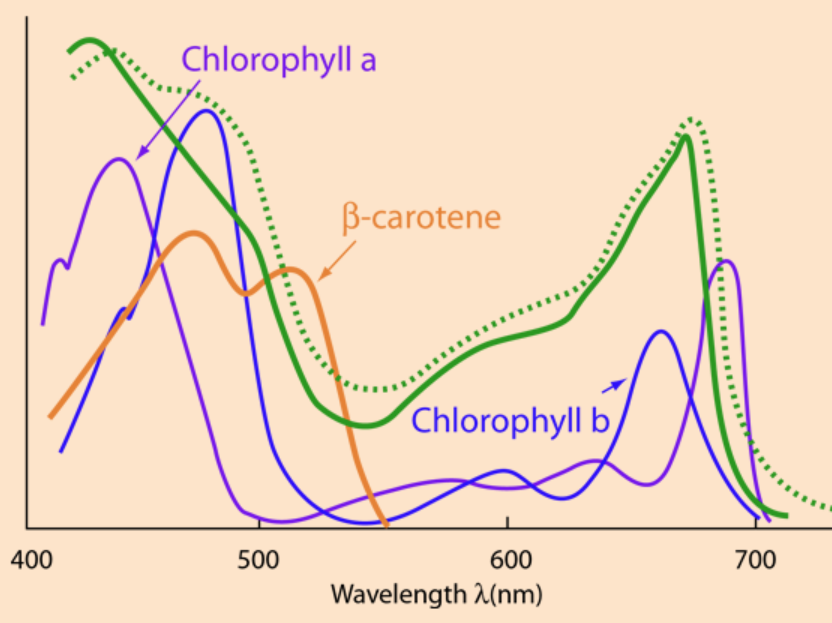

1. Can we convert the neurons to 'features' such as point values and ratios, or something similar that is more understandable?
2. Can we highlight these with lines, boxes, shaded regions?
3. Can we create a metric for each 'feature'?

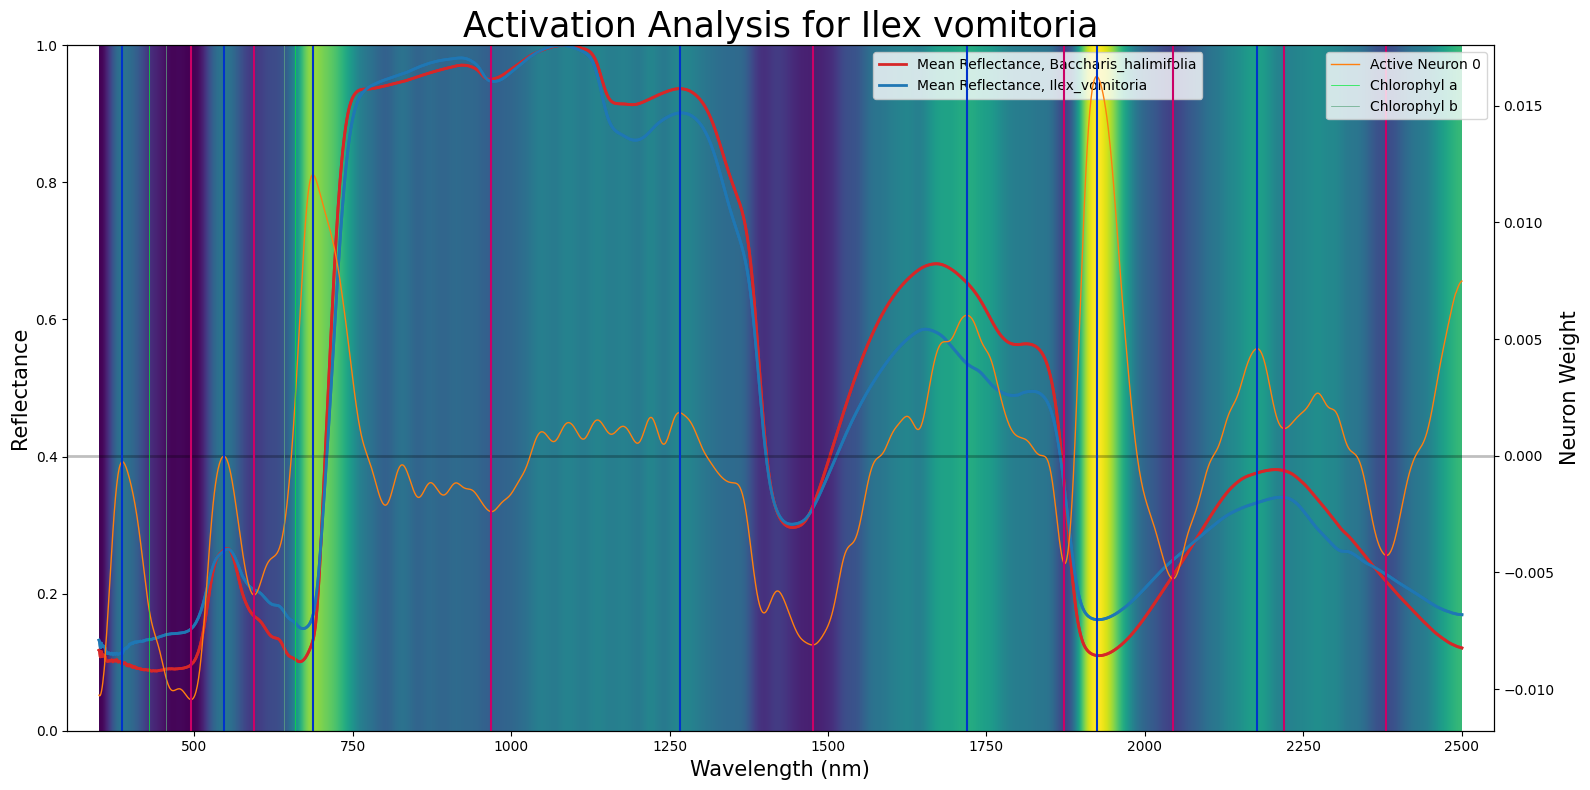

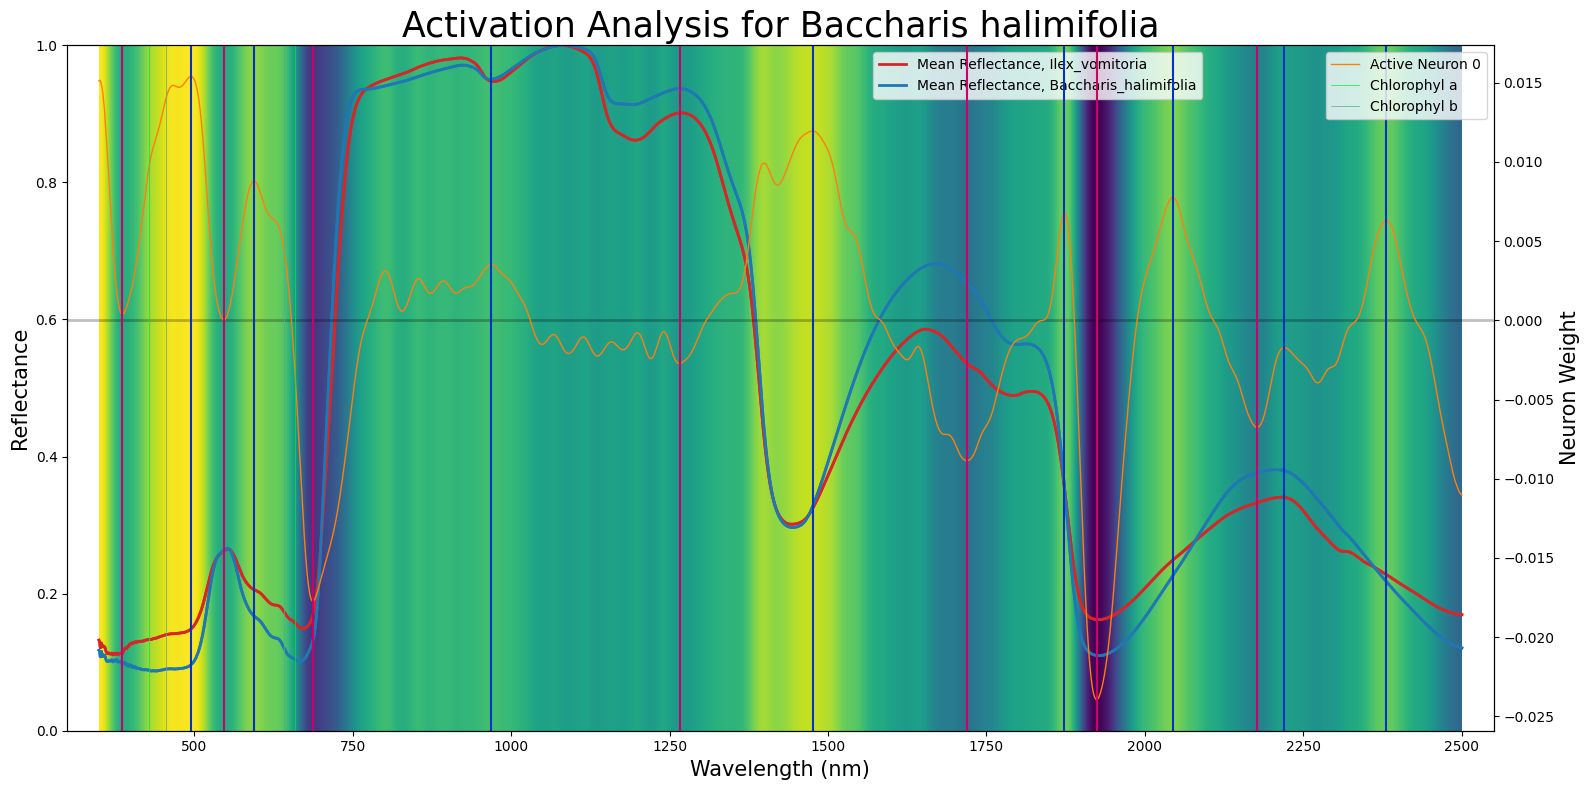

In [166]:
def plot_class_with_activation(max_neurons=4, smooth=True, plot_all_spectra = True, normalize_spectra=True, show_chlorophyl=True, lines_on_peaks=True):
    
    for idx in [[0,1],[1,0]]:
    
        # parameters for smoothing the neurons
        sigma = 10
        window = 20
        
        # Compute the mean spectrum for this class
        #class_mean = np.mean(spectra[np.where(name==class_name)[0],:], axis=0)
        # Compute the index in Y_labels for the name of this class
        #name_index = np.where(Y_labels==class_name)[0] 
        name_index = idx[0]
        # Determine the indices for the neurons in the first layer that are active for this class
        neuron_indices = np.where(np.abs(active_weights_2[name_index,:].flatten())>0)[0] 
        # Determine the amount of activation (weights in second layer) for this class
        neuron_activation = active_weights_2[name_index,neuron_indices]

        c = plt.rcParams['axes.prop_cycle'].by_key()['color'] # list of the default matplotlib colors
        
        fig, ax1 = plt.subplots(figsize=(16,8))       
        
        # shade background the plot based on the neuron
        neuronACt = neuron_activation[0]*active_weights_1[neuron_indices[0],:].flatten()
        neuronACt = scipy.ndimage.gaussian_filter1d(neuronACt, sigma)
        neuronACt = scipy.signal.savgol_filter(neuronACt, window, 3)
        neuronACt = scipy.signal.savgol_filter(neuronACt, window, 3)
        neuronACt = neuronACt-np.min(neuronACt)
        neuronACt = neuronACt/np.max(neuronACt)
        bkrnd = np.zeros((1000,len(wl)))
        for i in range(1000):
            bkrnd[i,:] = neuronACt 
        ax1.imshow(bkrnd, extent=[wl[0], wl[-1], 0, 1], aspect='auto', origin='lower', zorder=-1)
        
        # plot spectra from both classes
        for class_name, color in zip([Y_labels[idx[0]], Y_labels[idx[1]]], ['tab:red','tab:blue']):
            # plot class mean for alternative class
            class_mean = np.mean(spectra[np.where(name==class_name)[0],:], axis=0)
            ax1.plot(wl, normalize_spec(class_mean, normalize_spectra), color=color, lw=2, label=f'Mean Reflectance, {class_name}')
            # plot each spectra in the alternative class
            if plot_all_spectra:
                for i in np.where(name==class_name)[0]:
                    ax1.plot(wl, normalize_spec(spectra[i,:], normalize_spectra), color=color, lw=0.25, alpha=0.5)
                
        ax1.set_xlabel('Wavelength (nm)', fontsize=15) # first axis, for the spectrum
        ax1.set_ylabel('Reflectance', color='k', fontsize=15)
        ax1.tick_params(axis='y', labelcolor='k')
        plt.grid(False)
        plt.legend(loc='upper left', bbox_to_anchor=(0.56,1))

        ax2 = ax1.twinx()  # second axes, for neruon weights
        ax2.set_ylabel('Neuron Weight', color='k', fontsize=15) 
        ax2.plot([np.min(wl)-50,np.max(wl)+50], [0,0], color='k', alpha=0.25, lw=2)
        for i,n_i in enumerate(neuron_indices):
            color_index = (i+1) % (len(c)-1) # pick the next color looping through the list
            neuronACt = neuron_activation[i]*active_weights_1[n_i,:].flatten()
            if smooth:
                neuronACt = scipy.ndimage.gaussian_filter1d(neuronACt, sigma)
                neuronACt = scipy.signal.savgol_filter(neuronACt, window, 3)
                neuronACt = scipy.signal.savgol_filter(neuronACt, window, 3)
            ax2.plot(wl, neuronACt, color=c[color_index], lw=1, label='Active Neuron '+str(n_i))
            if lines_on_peaks:
                peaks, _ = find_peaks(neuronACt, rel_height=0.05, width=10)
                for peak_index in peaks:
                    plt.axvline(x=wl[peak_index], color='#0033cc')
                peaks, _ = find_peaks(-neuronACt, rel_height=0.05, width=10)
                for peak_index in peaks:
                    plt.axvline(x=wl[peak_index], color='#cc0066')
            if i == max_neurons-1:
                break
        
        ax2.tick_params(axis='y', labelcolor='k')
        ax2.grid(False)

        for class_name, color in zip([Y_labels[idx[0]], Y_labels[idx[1]]], ['tab:red','tab:blue']):
            # plot class mean for alternative class
            class_mean = np.mean(spectra[np.where(name==class_name)[0],:], axis=0)
            ax1.plot(wl, normalize_spec(class_mean, normalize_spectra), color=color, lw=2)
        plt.title(f'Activation Analysis for '+class_name.replace('_', ' '), fontsize=25)
        plt.xlim(np.min(wl)-50,np.max(wl)+50)
        
        if show_chlorophyl:            
            # Values from https://rseco.org/content/122-chlorophyll-absorption-and-photosynthetic-action-spectra.html
            plt.axvline(x=429, color='#02eb38', lw=0.5)
            plt.axvline(x=659, color='#02eb38', label='Chlorophyl a', lw=0.5)
            plt.axvline(x=455, color='#60a882', lw=0.5)
            plt.axvline(x=642, color='#60a882', label='Chlorophyl b', lw=0.5)
 
        
        plt.legend()
        fig.tight_layout()  
        plt.savefig('output/activation_'+class_name+'.png');
        plt.show()
        
        #plt.figure()
        #plt.imshow(bkrnd)

plot_class_with_activation(max_neurons=1, plot_all_spectra = False, smooth=True)

In [150]:
bkrnd = np.zeros((1000,len(wl)))
for i in range(1000):
    bkrnd[i,:] = neuronACt

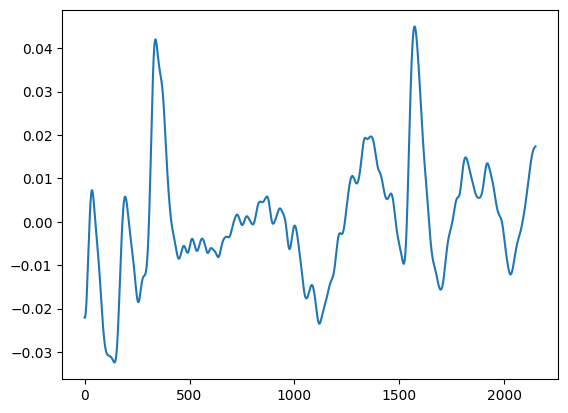

In [151]:
plt.plot(neuronACt)

In [152]:
plt

<module 'matplotlib.pyplot' from 'c:\\Users\\wb8by\\Documents\\GitHub\\NN_Hyperspectral_Vegetation\\.venv\\lib\\site-packages\\matplotlib\\pyplot.py'>